# Lecture 2.5: Susceptible, Infected and Recovered (SIR) Model

SIR model describes the spread of a disease throughout a population over time.
It is a compartmental model, which means that the population is divided into compartments, and each compartment has its own characteristics.
In this case, we will use the SIR model to describe the spread of a disease through a population.

The classic SIR model is described by a system of ordinary differential equations (ODEs) that express the variation of the number of individuals in each one of the 3 states over time, as follows: 
$$
\begin{align}
\frac{dS}{dt} &= -\beta \frac{SI}{N} \\
\frac{dI}{dt} &= \beta \frac{SI}{N} - \gamma I \\
\frac{dR}{dt} &= \gamma I,
\end{align}
$$
where 
- $S(t)$ is the number of **susceptible** individuals at time $t$. A susceptible individual is not yet infected and can become infected.
- $I(t)$ is the number of **infected** individuals at time $t$. An infected individual is infected and can spread the disease to others.
- $R(t)$ is the number of **recovered** individuals at time $t$. A recovered individual was infected, but is no longer infected or infectious.
- $N$ is the total population.
- $\beta$ is the infection rate.
- $\gamma$ is the recovery rate. 

Now let's interpret these equations:
- The **first equation** describes the rate of change in the number of susceptible individuals ($S$). As $S$ decreases as the population is infected, and an infected individual can infect a susceptible individual we can say that $\frac{dS}{dt} \propto S I$. The proportionality constant here is the infection rate $\beta \in [0,1]$. Finally the total population $N$ is included as a normalization factor to ensure that the number does not exceed the population size.
- The **second equation** is similar, but now the proportionality to the variation is positive, since the number of infected individuals ($I$)increases as susceptible individuals become infected. Here we also include the decrease of infected individuals as they recover, given by the recovery rate $\gamma \in [0,1]$.
- Finally, the **third equation** presents the rate of change of the number of recovered individuals ($R$). And it is basically the second term of the right hand side of the second equation, since the recovered individuals are the ones that are no longer infected.

_**Note** that the right hand side of the equations if sumed up is equal to zero, which makes sense, since the total population is constant over time._

Using an explicit finite difference approximation, we can discretize the equations considering a time step $\Delta t = 1$ day for simplicity, as follows:
$$
\begin{align}
S_{t+1} &= S_{t} - \beta \frac{S_{t} I_{t}}{N} \\
I_{t+1} &= I_{t} + \beta \frac{S_{t} I_{t}}{N} - \gamma I_{t} \\
R_{t+1} &= R_{t} + \gamma I(t),
\end{align}
$$
where $S_{t}$, $I_{t}$ and $R_{t}$ are the number of susceptible, infected and recovered individuals at time $t$, respectively.
Given an initial condition $I_{0}$ ($R_{0} = 0$ and $S_{0} = N - I_{0}$), we can compute the number of individuals in each state at each time step.

As said before, the SIR model is a simple model that can be used to describe the spread of a disease in a population. However, it may be not very realistic, since it does not take into account different aspects of the disease, population dynamics, interventions, etc.

In this lecture we will see how sensitivity analysis can help to improve the model and make it closer to your study interests.

### Importing the required libraries

Again, to provide a better understanding of the problem, only the packages `SALib`, `numpy`, and `matplotlib` will be used.

In [1]:
from SALib import ProblemSpec

import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

plt.rcParams["font.family"] = "serif"

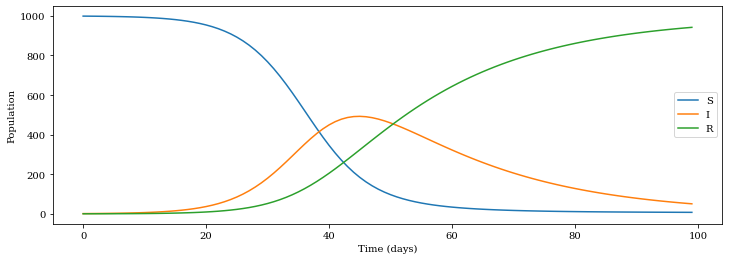

In [2]:
def simple_sir_model(beta, gamma, I0, N, tf=100):
    
    S = np.zeros(tf)
    I = np.zeros(tf)
    R = np.zeros(tf)

    S[0] = N - I0
    I[0] = I0
    R[0] = 0

    for t in range(1, tf):
        S[t] = S[t-1] - beta*S[t-1]*I[t-1]/N
        I[t] = I[t-1] + beta*S[t-1]*I[t-1]/N - gamma*I[t-1]
        R[t] = R[t-1] + gamma*I[t-1]
        
    return S, I, R

final_time = 100

s, i, r = simple_sir_model(0.25, 0.05, 1, 1000, final_time)

t = np.arange(0, final_time, 1)

plt.figure(figsize=(12, 4))
plt.plot(t, s, label="S")
plt.plot(t, i, label="I")
plt.plot(t, r, label="R")
plt.xlabel("Time (days)")
plt.ylabel("Population")
plt.legend()
plt.show()

### Defining the Analysis Problem

The following analysis will run on the 3 outputs of the model: $S$, $I$ and $R$. But as we will propose some interventions in the model, let's define some useful functions to compute the Sobol indices and plot them.

In [3]:
# defining colors and latex symbols for plotting
colors = ['red', 'blue', 'green', 'purple', 'orange', 'black', 'brown', 'pink', 'gray', 'olive']
latex_symbols = {   'beta': '\\beta',
                    'gamma': '\\gamma'
                }

In [4]:
def sa_wrapper(rv_params, f, I0, N, tf=100):
    
    pops = np.zeros((rv_params.shape[0], tf, 3))
    for i, rv_param in enumerate(rv_params):
        aux = f(*rv_param, I0, N, tf)
        pops[i] = np.array(aux).T

    return pops.reshape(rv_params.shape[0], -1)

def evaluate_sa(problem, I0, N, tf=100, sir_model=simple_sir_model):
    '''
    Evaluate Sobol indices for the SIR model.
    
    Parameters
    ----------
    problem : dict
        Problem definition.
    I0 : int
        Initial number of infected individuals.
    N : int
        Total population size.
    tf : int
        Final time and the number of time steps.
    wrapped_sir_model : function
        Function that wraps the desired SIR model.
    '''
    sp = ProblemSpec(problem)

    wrapped_model = lambda rv_params: sa_wrapper(rv_params, sir_model, I0, N, tf)

    n_samples = 2**10
    sp.sample_sobol(n_samples) \
        .evaluate( wrapped_model ) \
        .analyze_sobol()

    S1s = np.array([sp.analysis[_y]['S1'] for _y in sp['outputs']])
    STs = np.array([sp.analysis[_y]['ST'] for _y in sp['outputs']])

    evaluations = sp.results

    return S1s, STs, evaluations

def plot_sa(S1s, STs, evaluations, tf=100, input_names=['beta','gamma'], output_names=['S', 'I', 'R']):
    '''
    Plot Sobol indices and model evaluations.

    Parameters
    ----------
    S1s : array
        First-order Sobol indices.
    STs : array
        Total-order Sobol indices.
    evaluations : array
        Model evaluations.
    tf : int
        Final time and the number of time steps.
    input_names : list
        List of input names. The parameters to be analy
    output_names : list
        List of output names.

    '''
            
    t = np.arange(0, tf, 1)

    evaluations = evaluations.reshape((-1, t.shape[0], 3))
    S1s = S1s.reshape((t.shape[0], 3, 2))
    STs = STs.reshape((t.shape[0], 3, 2))

    fig, ax = plt.subplots(2*len(output_names), 1, sharex=True, figsize=(18, 12))
    for o, okey in enumerate(output_names):
        for i, ikey in enumerate(input_names):
            ax[2*o].plot(t, S1s[:,o,i], label=rf'${latex_symbols[ikey]}\, \mathcal{{S}}_1$', color=colors[i])
            ax[2*o].plot(t, STs[:,o,i], '--', label=rf'${latex_symbols[ikey]}\, \mathcal{{S}}_T$', color=colors[i])
        ax[2*o].set_ylabel('Sobol indices')

        median = np.median(   evaluations[:,:,o], axis=0)
        upper = np.percentile(evaluations[:,:,o], 95, axis=0)
        lower = np.percentile(evaluations[:,:,o], 5, axis=0)
        ax[2*o+1].plot(t, median, label='median')
        ax[2*o+1].fill_between(t, lower, upper, alpha=0.5, label='95% confidence interval')
        ax[2*o+1].set_xlabel('Time (days)')
        ax[2*o+1].set_ylabel(rf'${okey}$')

    ax[0].legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

    plt.subplots_adjust(wspace=0, hspace=0)
    plt.show()

    return fig, ax

def run_sensitivity_analysis(problem, I0, N, tf=100, sir_model=simple_sir_model, output_names=['S', 'I', 'R']):
    '''
    Run the sensitivity analysis pipeline for the SIR model.
    Parameters described in its respective functions.
    '''
    S1s, STs, evaluations = evaluate_sa(problem, I0, N, tf, sir_model)
    fig, ax = plot_sa(S1s, STs, evaluations, tf, problem['names'], output_names)

    return S1s, STs, evaluations, fig, ax

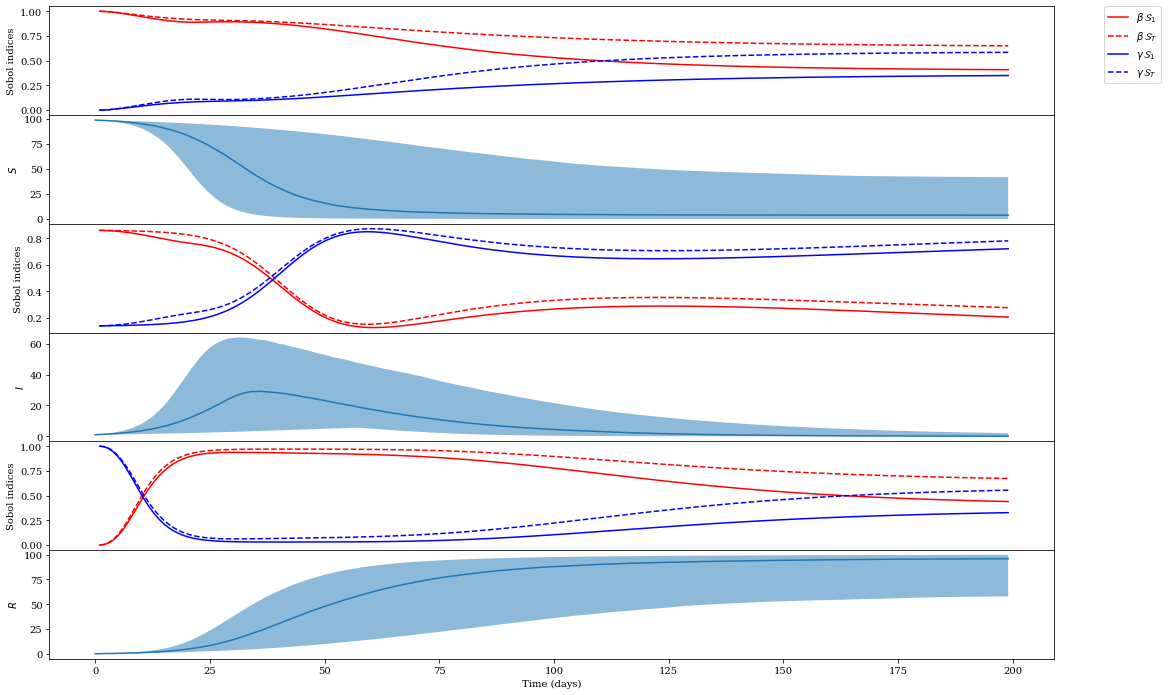

In [5]:
# constant input parameters
pop_size = 100
I0 = 1
final_time = 200

problem = {
    'num_vars': 2, 
    'names': ['beta', 'gamma'],
    'bounds': [[0.1, 0.3], [0.02, 0.1]],
}

output_names = ['S', 'I', 'R']

S1s, STs, evaluations, fig, ax = run_sensitivity_analysis(problem, I0, pop_size, final_time)

As expected by our first interpretation of the system of equations during the spread of a disease, the infection rate $\beta$ is the most important parameter, since it is the one that controls the number of infected individuals. The actual definition of $\beta$ considers a constant value, neglecting any response over time due to interventions, such as social distancing, use of masks, etc. This can be modeled by introducing a term that captures the impact of behavioral changes on the transmission rate.

So let's rewrite $\beta$ considering a behavioral factor
$$
    \beta(t) = \beta_0 + \delta \cdot B(t),
$$
where, $\beta_0$ represents the baseline transmission rate without any behavioral changes. $\delta$ is a parameter that determines the strength of the behavioral response, and $B(t)$ represents a behavioral factor that varies over time that can be a function that captures changes in behavior due to various factors such as public health interventions, awareness campaigns, or social distancing measures. For instance, $B(t)$ will be defined as a sigmoidal function that increases from 0 to 1 and then decreases back to 0 over time:
$$
    B(t) = \frac{1}{1 + e^{-k(I/N - c)}},
$$
$k$ controls the steepness of the curve, which means how fast the behavioral changes take effect,
and $c$ represents the proportion of infected individuals at which the behavioral changes start.

The recovery rate $\gamma$ can be affected by natural loss of immunity, which can be incorporated modifying the equation as follows:
$$
    \gamma(t) = \gamma_0 + \alpha \cdot R(t),
$$
where $\gamma_0$ is the baseline recovery rate without any loss of immunity, $\alpha$ is a parameter that determines the strength of the loss of immunity, and $R(t)$ is the already defined recovered individuals.

Rewriting the system of equations considering the new definition of $\beta(t)$:

$$
\begin{align}
\frac{dS}{dt} &= -\beta(t;\beta_0,\delta,k,c) \frac{SI}{N} \\
\frac{dI}{dt} &= \beta(t;\beta_0,\delta,k,c) \frac{SI}{N} - \gamma(t;\gamma_0, \alpha) I \\
\frac{dR}{dt} &= \gamma(t;\gamma_0, \alpha) I.
\end{align}
$$

Every hyperparameter inside the functions $\beta(t)$ and $\gamma(t)$ can be considered as a random variable, and the Sobol indices can be computed to understand the impact of each one of them on the outputs of the model.

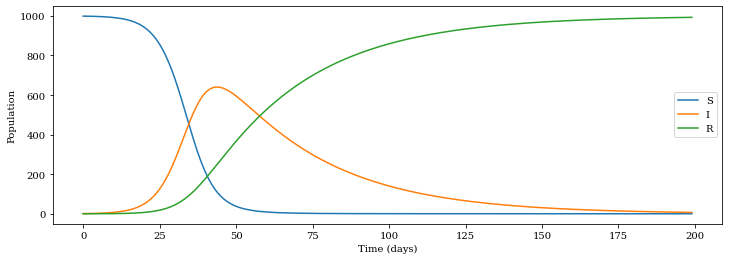

In [16]:
def simple_sir_model(beta0, delta, k, c, gamma0, alpha, I0, N, tf=100):
    
    S = np.zeros(tf)
    I = np.zeros(tf)
    R = np.zeros(tf)

    S[0] = N - I0
    I[0] = I0
    R[0] = 0

    def beta(t,I):
        # if abs(I-c*N) < 1e-6:
        #     return beta0
        return beta0 + delta/( 1-np.exp(-k*(I-c*N)) )
    
    def gamma(R):
        return gamma0 + alpha*R


    for t in range(1, tf):
        S[t] = S[t-1] - beta(t,I[t])*S[t-1]*I[t-1]/N
        I[t] = I[t-1] + beta(t,I[t])*S[t-1]*I[t-1]/N - gamma(R[t])*I[t-1]
        R[t] = R[t-1] + gamma(R[t])*I[t-1]
        
    return S, I, R

final_time = 200

s, i, r = simple_sir_model(beta0=0.25, delta=0.5, k=0.5, c=0.3, gamma0=0.03, alpha=0.3, I0=1, N=1000, tf=final_time)

t = np.arange(0, final_time, 1)

plt.figure(figsize=(12, 4))
plt.plot(t, s, label="S")
plt.plot(t, i, label="I")
plt.plot(t, r, label="R")
plt.xlabel("Time (days)")
plt.ylabel("Population")
plt.legend()
plt.show()